# NOT COMPLETE - needs to be bundled with Task session code 

# Run rastermap for Figure 3 (motor system) plots for Neuropixels NHP paper
# 2022-08-30
# Eric Trautmann 

# Imports

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
from tqdm import tqdm
import xarray as xr
import os
import sys 
import h5py
import pprint
import warnings
import timeit
import re
import csv
from datetime import datetime

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# from dPCA import dPCA
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
util_path = os.path.abspath(os.path.join('../util'))
if util_path not in sys.path:
    sys.path.append(util_path)

sys.path.append('/Users/erictrautmann/Dropbox/shenoy_lab/code/rastermap')
from rastermap import Rastermap

# from ..util import pacman_utils as util
import task_session as ts 
import pacman_plots as pp
import pacman_utils as util

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

from icecream import ic

ModuleNotFoundError: No module named 'task_session'

# Load data

In [2]:
# data_root = '/Volumes/emt_ssd_2/data'
data_root = '/Users/erictrautmann/data/'
# date = "2021-05-25"
date = "2021-03-18"
# date = "2022-01-31"

date_short = date.replace("-","")[2:] # convert from yyyy-mm-dd to yymmdd
data_path = f"{data_root}pacman-task/cousteau/processed/{date}/mergedTaskData/pacman-task_c_{date_short}_taskdata.mat"
fig_path = f'/Users/erictrautmann/Dropbox/columbia/figures/pacman-decisions/cousteau/pacman-gain-switch/{date}/'
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)
    

# Initialize Task session object
TS = ts.TaskSession(data_path)

100%|██████████| 6/6 [00:36<00:00,  6.02s/it]


In [39]:
TS.conds_df

,cond_id,gain,type,output_amp,duration,frcMax,offset,padDur,previousGain,block
0,0,-1.0,SIN,9.1,4.0,14.0,14.0,1.0,"[-1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1...",1.0
1,1,-1.0,CHP,7.0,4.0,14.0,14.0,1.0,"[1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1...",1.0
2,2,-1.0,SIN,5.6,4.0,14.0,14.0,1.0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1...",1.0
3,3,1.0,SIN,5.6,4.0,14.0,0.0,1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1...",1.0
4,4,1.0,CHP,7.0,4.0,14.0,0.0,1.0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1....",1.0
5,5,1.0,SIN,9.1,4.0,14.0,0.0,1.0,"[-1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, ...",1.0


In [65]:
data = TS.xarray_ds

# downselect to specific conditions

conds = TS.conds_df
cond_type= 'SIN'
pos = conds.query('gain == 1').cond_id.tolist()
neg = conds.query('gain < 0 ' ).cond_id.tolist()


ic(pos)
ic(neg)

# shape data for PCA
time_slice = slice(0,5000,5)
ds = TS.xarray_ds
X = ds.psths.sel(time=time_slice, condition=[1]).transpose('time','condition','neuron')

# normalize
X_norm = util.softnorm(X)
X = X_norm.stack(TC=('condition','time')).to_numpy()

# X_pos = X_norm.sel(condition=pos)
# X_neg = X_norm.sel(condition=neg)



ic| pos: [3, 4, 5]
ic| neg: [0, 1, 2]


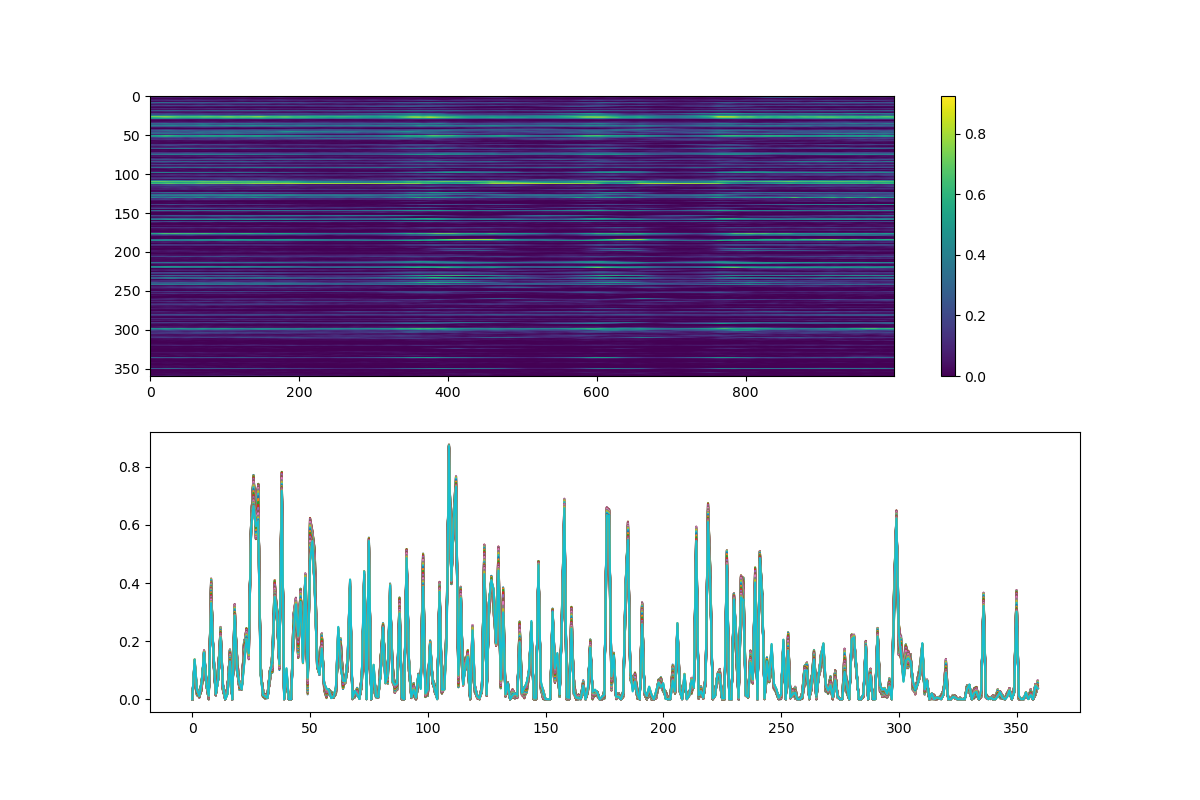

In [66]:
fig, ax = plt.subplots(2,1,figsize=(12,8))
pos = ax[0].imshow(X.data,aspect='auto')
fig.colorbar(pos,ax = ax[0])
ax[1].plot(X[:,0:50]);

In [67]:
from rastermap import Rastermap
model = Rastermap(n_components=2, n_X=100).fit(X) 
ic(model.embedding.shape)

nmin 200
0.0006489753723144531
0.3179609775543213
0.3220369815826416
0.32300591468811035
(9800, 10000)
(130,)
1.0
time; iteration;  explained PC variance
0.11s     0        0.8641      8
1.07s    10        0.9630      24
2.02s    20        0.9736      80
3.42s    30        0.9823      360
5.05s    40        0.9880      840
7.14s    50        0.9899      1520
9.76s    60        0.9898      2400
13.37s    70        0.9906      3480
17.89s    80        0.9907      4760
23.19s    90        0.9914      6240
29.49s    100        0.9919      7920
36.92s    110        0.9920      9800
45.77s    120        0.9920      9800
53.79s   final      0.9920


ic| model.embedding.shape: (360, 2)


56.78s upsampled    0.9920


(360, 2)

In [60]:
isort = model.embedding[:,0]
ic(isort.shape)

ic| isort.shape: (360,)


(360,)

In [54]:
isort

array([0, 1])

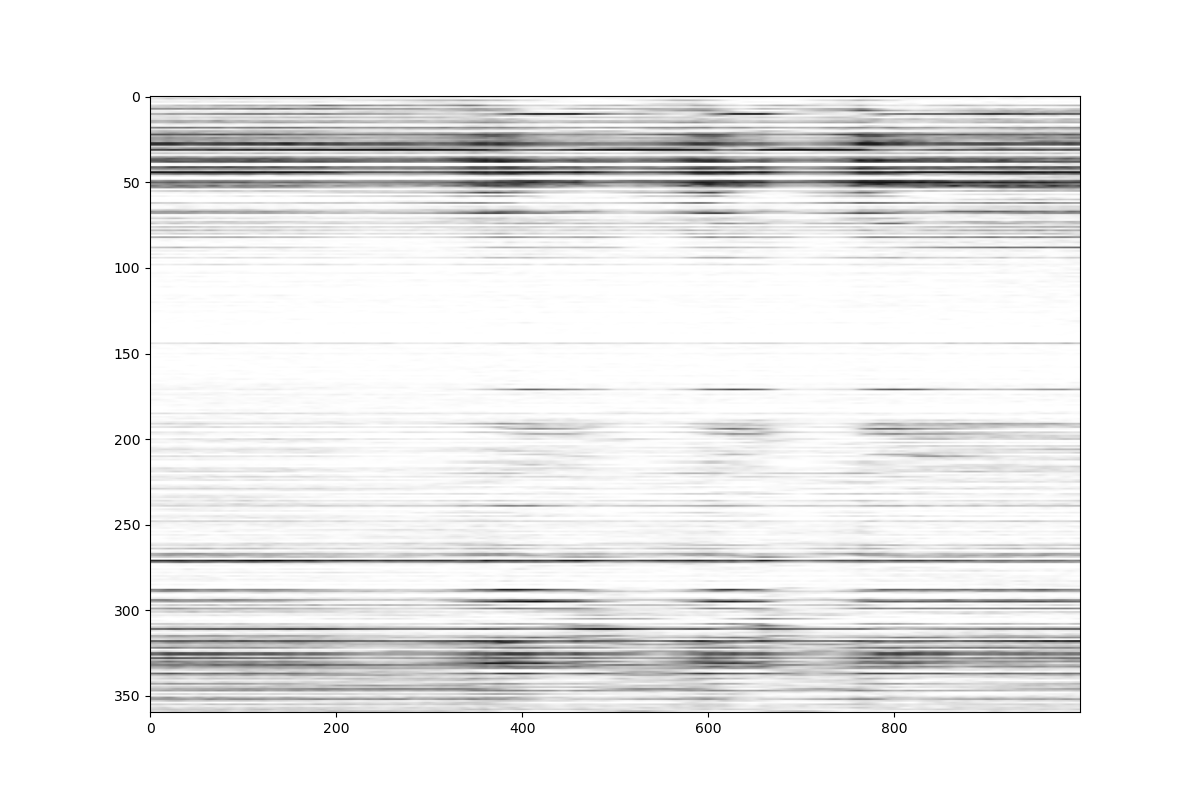

In [68]:
isort = np.argsort(model.embedding[:,0])

fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.imshow(X[isort, :],aspect='auto', cmap='gray_r')


# fit_transform returns embedding (upsampled cluster identities)
# embedding = model.fit_transform(X)

# transform can be used on new samples with the same number of features as sp
# embed2 = model.transform(sp2)

In [11]:
# the manifold embedding is in model.embedding



# sort by embedding and smooth over neurons
# Sfilt = running_average(S[isort, 2000:2500], 50)
# Sfilt = stats.zscore(Sfilt, axis=1)

In [12]:
isort.shape

(1,)

In [13]:
a = model.isort
a.shape

(6000,)

In [18]:
dir(model)

['A',
 'E',
 'K',
 'S',
 'X0',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_create_2D_basis0',
 '_map',
 'alpha',
 'annealing',
 'cmap',
 'constraints',
 'embedding',
 'fit',
 'fit_transform',
 'init',
 'isort',
 'lam',
 'mode',
 'nPC',
 'n_X',
 'n_components',
 'transform',
 'u',
 'v',
 'verbose',
 'vscale',
 'xid']

In [14]:
model.n_X

100

# Try 2 using demo notebook code

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from six.moves import urllib
import os
from scipy.stats import zscore


# download 2-photon data
if not os.path.isfile('data/stimspont.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    with urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/stimspont.npy') as response:
        with open('data/stimspont.npy','wb') as f:
            f.write(response.read())

In [40]:


# load downloaded data
dat = np.load('data/stimspont.npy',allow_pickle=True) 
dat = dat.item()
resp  = dat['resp']   # stimulus responses x neurons
istim  = dat['istim'] # identity of stimulus (0-31)
resp = zscore(resp, axis=1)



In [45]:
import sys
# path to your local download of rastermap
# sys.path.append('/media/carsen/DATA2/Github/rastermap/rastermap/')
sys.path.append('/Users/erictrautmann/Dropbox/shenoy_lab/code/rastermap')
from rastermap import Rastermap

# rastermap works the same as TSNE or UMAP
# create an instance of the Rastermap class
# class Rastermap:
"""rastermap embedding algorithm
    Rastermap first takes the top iPC's of the data, and then embeds them into
    n_X clusters. It returns upsampled cluster identities (n_X*upsamp).
    Clusters are also computed across Y (n_Y) and smoothed, to help with fitting.
    If n_components=2, n_X x n_X components are used.
    
    Parameters
    -----------
    n_components: int, optional (default: 1)
        dimension of the embedding space
    n_X: int, optional (default: 40)
        number of clusters in X
    n_Y: int, optional (default: 0)
        number of clusters in Y: will be used to smooth data before sorting in X
        if set to zero, no smoothing will occur
    iPC: nparray, int, optional (default: 0-399)
        which PCs to use during optimization
    nPC: int, optional (default: 400)
        if used, will take 0-nPC PCs during optimization
    init : initialization of algorithm (default: 'pca')
        can use 'pca', 'random', or a matrix n_samples x n_components
"""

model = Rastermap(n_components=2, n_X=40, nPC=400, init='pca')
out = model.fit_transform(resp)



nmin 400
0.011132001876831055
26.394989013671875
26.689911127090454
26.693186044692993
(1520, 1600)
(70,)
1.0
time; iteration;  explained PC variance
0.24s     0        0.0533      8
1.87s    10        0.2690      24
3.51s    20        0.4438      80
5.43s    30        0.6217      360
7.50s    40        0.7012      840
10.47s    50        0.7832      1520
13.90s    60        0.7845      1520
16.83s   final      0.7845
22.11s upsampled    0.7845


In [49]:
model.isort



array([1814,  256,  439, ..., 2400, 2585, 2366])

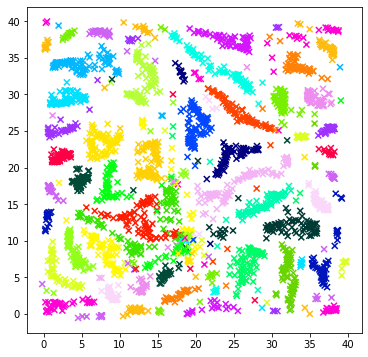

In [46]:


# plot results here
%matplotlib inline
cmap = cm.get_cmap('gist_ncar')
cmap = cmap(np.linspace(0,.97,32))
cmap = cmap[np.random.permutation(32),:]
plt.figure(figsize=(6,6))
# each point is colored based on stimulus identity
plt.scatter(out[:,0],out[:,1],color=cmap[istim,:],marker='x')
plt.show()

        

In [47]:


# classify results
import sklearn.neighbors

# classifier
n_neighbors = 1
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
# fit classifier using half of the data
# low-dimensional data
svc = clf.fit(out[::2,:],istim[::2])
# predict stimuli from other half
istim_pred = clf.predict(out[1::2,:])
accuracy   = (istim_pred==istim[1::2]).mean()
print('stimulus classification accuracy: %2.3f'%accuracy)



stimulus classification accuracy: 0.944
